# Pipeline

1. Preprocessing
2. Data Extraction
3. Data Exploration
4. **Model**

This file initializes the model and makes predictions too.

# Imports

In [254]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [422]:
# Get feature dataframe from pickle file
df = pd.read_pickle('feature_frame.pkl')

In [105]:
df.sample(5)

,HomeID,AwayID,FTHG,FTAG,FTR,Date,H_WIN_PCT_home,H_DRAW_PCT_home,A_WIN_PCT_home,A_DRAW_PCT_home,...,REL_PTS_1_away,REL_PTS_2_away,REL_PTS_3_away,REL_PTS_4_away,REL_PTS_5_away,REL_PTS_N-0_away,REL_PTS_N-1_away,REL_PTS_N-2_away,REL_PTS_N-3_away,REL_PTS_N-4_away
6173,50,53,8,1,1,2019-05-18,0.303030,0.393939,0.314286,0.257143,...,1.352941,1.294118,1.000000,0.764706,0.676471,-0.323529,-0.117647,0.000000,0.029412,0.117647
11820,111,100,1,1,0,2016-04-17,0.736842,0.157895,0.270270,0.297297,...,1.151515,1.151515,1.121212,0.723485,0.484848,-0.303030,-0.272727,-0.242424,-0.182765,-0.060606
8275,66,86,2,0,1,2016-01-24,0.487179,0.230769,0.486486,0.189189,...,0.961905,0.861905,0.761905,0.714286,0.511905,-0.476190,-0.388095,-0.188095,-0.138095,-0.088095
7238,81,77,2,0,1,2013-04-07,0.567568,0.297297,0.368421,0.315789,...,1.419355,1.129032,1.000000,0.806452,0.795699,-0.070968,0.000000,0.195699,0.295699,0.322581
10765,113,108,2,2,0,2013-09-14,0.368421,0.473684,0.250000,0.200000,...,0.500000,0.500000,0.000000,0.000000,-0.500000,-2.166667,-2.166667,-2.166667,-2.000000,-2.000000


# Extracting target variables and features

# _WICHTIG: Das hier muss auf neue columns angepasst werden (z.B. season)_

In [517]:
# If True, the goal difference for a specific game is seen as the target variable.
# (e.g. -3 for a game outcome of 1:4, or 2 for 3:1) .

# If False, we just want to predict the winner.
# 1 = Home team wins, 0 = Draw, 2 = Away team wins
predict_goal_difference = False

if predict_goal_difference:
    y = df['FTHG'] - df['FTAG']
else:
    y = df['FTR']
    
# Remove unnecessary columns (IDs etc.) from features
X = df.iloc[:,6:].drop(['season', 'GAME_CNT_AFTER_GAME_home', 'GAME_CNT_AFTER_GAME_away', 'league', 'PTS_AFTER_GAME_home', 'PTS_AFTER_GAME_away'], axis=1)    
#X = df[['EGD', 'H_RTG_home', 'H_RTG_away', 'A_RTG_home', 'A_RTG_away']]
#X['FTR'] = df['FTR']

In [ ]:
df.iloc[:,6:].drop(['season', 'GAME_CNT_AFTER_GAME_home', 'GAME_CNT_AFTER_GAME_away'], axis=1).columns

# Ranked Probability Score (RPS)

In [128]:
def rps(pred, actual_value, r=3):
    '''Returns the ranked probability score for a single given game.
    (see Hubacek paper for formula)
    
    Arguments:
    pred -- predicted results; in vector form (e.g. [0.1, 0.6, 0.3])
    actual_value -- actual result (0, 1 or 2); not in vector form yet
    r -- number of categories (3 for football)
    '''
    value_vec = [0, 0, 0]
    
    # Bring value_vec into 1, 0, 2 order
    if actual_value == 0:
        value_vec[1] = 1
    elif actual_value == 2:
        value_vec[2] = 1
    elif actual_value == 1:
        value_vec[0] = 1
    else:
        print(actual_value)
        raise Exception('Prediction was not in [1, 0, 2].')
    #value_vec = [0, 0, 1]
    
    #print(pred)
    #print("pred:", pred, "vec:", value_vec, "actualval:", actual_value)
    pred[0], pred[1], pred[2] = pred[1], pred[0], pred[2]   # order: loss, draw, win
    #print("pred:", pred, "vec:", value_vec, "actualval:", actual_value)
    
    rps = 0
    
    for i in range(0, r-1):
        inner_sum = 0
        for j in range(0, i+1):
            inner_sum += (pred[j] - value_vec[j])
        rps += np.square(inner_sum)
    
    rps /= (r-1)
    
    return rps


# To be used as eval_metric parameter
def rps_eval_metric(y_true, y_pred):
    return rps(y_pred, y_true)

# Model fit

In [424]:
list_test_accu = []
list_train_accu = []
list_rs = []

## Find best value for *n_estimators*

In [ ]:
# We start with n_estimators=50...
xgb_cl = xgb.XGBClassifier(objective='multi:softprob', n_estimators=50, seed=16)
# ...and then validate it to find the lowest loss.
op = xgb_cl.fit(X_train, y_train, early_stopping_rounds=900, eval_metric='mlogloss', eval_set=[(X_test, y_test)])

In [ ]:
learning_rates = [0.2, 0.3, 0.4]
n_estimators = [8, 16, 32]
subsamples = [0.6, 0.8, 0.9, 1]
colsample_bytree = [0.5, 0.75, 0.9, 1]
max_depth = [3, 6, 8, 12]
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rates, subsample=subsamples, colsample_bytree=colsample_bytree, max_depth=max_depth)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
grid = GridSearchCV(estimator=xgb_cl, param_grid=param_grid, n_jobs=8, cv=3)
grid_result = grid.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

## Use best parameters to fit the model

In [519]:
# Apparently the random states are pretty important. 21 works very well on RPS and test accuracy, 16 only on accuracy.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=543)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [520]:
# n_estimators=8 had the lowest loss, so we overwrite the previous model.b
#xgb_cl = xgb.XGBClassifier(objective='multi:softprob', n_estimators=64, seed=16, learning_rate=0.2, subsample=1, colsample_bytree=0.6, max_depth=4)
xgb_cl = xgb.XGBClassifier(objective='multi:softprob', n_estimators=64, learning_rate=0.2, subsample=1, colsample_bytree=0.6, max_depth=4)

In [521]:
xgb_cl.fit(X_train, y_train)

[21:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=64, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluation

In [522]:
preds = xgb_cl.predict(X_test)
accuracy = float(np.sum(preds == y_test))/y_test.shape[0]

print(f'accuracy: {accuracy}')
list_test_accu.append(accuracy)

accuracy: 0.5888831967213115


In [523]:
# Looking at train set accuracy to get an intuition of how much the model overfits
preds = xgb_cl.predict(X_train)
accuracy = float(np.sum(preds == y_train))/y_train.shape[0]

print(f'accuracy on train set: {accuracy}')
list_train_accu.append(accuracy)

accuracy on train set: 0.70344751866491


In [524]:
# Predictions in form of [0.2, 0.5, 0.3] in the order of draw, home win, away win.
# This is because it gets ordered like 0, 1, 2.
proba_preds = xgb_cl.predict_proba(X_test)

# List of RPS scores for every game in the test set.
# Important to use iloc for y_test, otherwise indices would be wrong
rps_list = [rps(pred, y_test.iloc[i]) for i, pred in enumerate(proba_preds)]

#proba_preds

#rps(proba_preds[0], y_test.iloc[0])

# Average ranked probability score.
print(np.mean(rps_list))
list_rs.append(np.mean(rps_list))

0.17159769359114313


In [516]:
#print(list_test_accu)
#print(list_train_accu)
#print(list_rs)
print(np.mean(list_test_accu))
print(np.mean(list_train_accu))
print(np.mean(list_rs))

0.45156841109709955
0.50693388736867
0.2299552328265032


In [19]:
# league priors -> rps (DO NOT RUN AGAIN)
r_list = []
for i in range(len(X_test.index)):
    league = X_test.iloc[i]['league']
    prob_vector = []
    if league == 'D1':
        prob_vector = [0.2422, 0.4582, 0.2996]
    elif league == 'E1':
        prob_vector = [0.2468, 0.4576, 0.2956]
    elif league == 'I1':
        prob_vector = [0.2575, 0.4538, 0.2888]
    elif league == 'SP1':
        prob_vector = [0.2371, 0.4781, 0.2848]
    
    r_list.append(rps(prob_vector, y_test.iloc[i]))
    
np.mean(r_list)

0.22572732173924184

In [51]:
# global priors -> rps
r_list = []
for i in range(len(y_test.index)):
    r_list.append(rps([0.2921845, 0.46192225, 0.24589325], y_test.iloc[i]))
np.mean(r_list)

0.22946942640115262

## Feature importances

In [241]:
for k in zip(X.columns, xgb_cl.feature_importances_):
    print(k)

('H_WIN_PCT_home', 0.009969974)
('H_DRAW_PCT_home', 0.0083714025)
('A_WIN_PCT_home', 0.009886505)
('A_DRAW_PCT_home', 0.0057212007)
('H_WIN_PCT_away', 0.010039404)
('H_DRAW_PCT_away', 0.007570091)
('A_WIN_PCT_away', 0.0078016887)
('A_DRAW_PCT_away', 0.0074010757)
('H_GS_AVG_home', 0.008804651)
('H_GC_AVG_home', 0.008095864)
('A_GS_AVG_home', 0.0082171)
('A_GC_AVG_home', 0.007244578)
('H_GS_AVG_away', 0.009246362)
('H_GC_AVG_away', 0.007799683)
('A_GS_AVG_away', 0.008065052)
('A_GC_AVG_away', 0.007243647)
('H_GS_STD_home', 0.005962068)
('H_GC_STD_home', 0.0067847776)
('A_GS_STD_home', 0.008046839)
('A_GC_STD_home', 0.008102134)
('H_GS_STD_away', 0.009563463)
('H_GC_STD_away', 0.006416428)
('A_GS_STD_away', 0.00849723)
('A_GC_STD_away', 0.007552533)
('WIN_PCT_home', 0.013577162)
('WIN_PCT_away', 0.013541383)
('DRAW_PCT_home', 0.008114115)
('DRAW_PCT_away', 0.0)
('GS_AVG_home', 0.0068756)
('GC_AVG_home', 0.0073862933)
('GS_AVG_away', 0.0085540535)
('GC_AVG_away', 0.007860765)
('GS_STD_hom

In [242]:
fbuckets = []
for i in range(len(xgb_cl.feature_importances_)):
    if i < 24:
        fbuckets.append('Historical strength')
    elif 24 <= i < 38:
        fbuckets.append('Current form')
    elif 38 <= i < 47:
        fbuckets.append('League')
    elif 47 <= i < 52:
        fbuckets.append('Pi-ratings')
    elif 52 <= i < 54:
        fbuckets.append('Current form')
    elif 54 <= i < 58:
        fbuckets.append('Historical strength')
    elif i >= 58:
        fbuckets.append('Match importance')
    else:
        fbuckets.append('unknown')

In [243]:
for k in zip(X.columns, xgb_cl.feature_importances_, fbuckets):
    print(k)

('H_WIN_PCT_home', 0.009969974, 'Historical strength')
('H_DRAW_PCT_home', 0.0083714025, 'Historical strength')
('A_WIN_PCT_home', 0.009886505, 'Historical strength')
('A_DRAW_PCT_home', 0.0057212007, 'Historical strength')
('H_WIN_PCT_away', 0.010039404, 'Historical strength')
('H_DRAW_PCT_away', 0.007570091, 'Historical strength')
('A_WIN_PCT_away', 0.0078016887, 'Historical strength')
('A_DRAW_PCT_away', 0.0074010757, 'Historical strength')
('H_GS_AVG_home', 0.008804651, 'Historical strength')
('H_GC_AVG_home', 0.008095864, 'Historical strength')
('A_GS_AVG_home', 0.0082171, 'Historical strength')
('A_GC_AVG_home', 0.007244578, 'Historical strength')
('H_GS_AVG_away', 0.009246362, 'Historical strength')
('H_GC_AVG_away', 0.007799683, 'Historical strength')
('A_GS_AVG_away', 0.008065052, 'Historical strength')
('A_GC_AVG_away', 0.007243647, 'Historical strength')
('H_GS_STD_home', 0.005962068, 'Historical strength')
('H_GC_STD_home', 0.0067847776, 'Historical strength')
('A_GS_STD_ho

In [244]:
from collections import defaultdict
f_impor_perbucket = defaultdict(lambda: 0)
for k in zip(xgb_cl.feature_importances_, fbuckets):
    f_impor_perbucket[k[1]] += k[0]

In [245]:
dict(f_impor_perbucket)

{'Historical strength': 0.22930977679789066,
 'Current form': 0.11988692032173276,
 'League': 0.0628380193375051,
 'Pi-ratings': 0.03779119439423084,
 'Match importance': 0.5501739839091897}

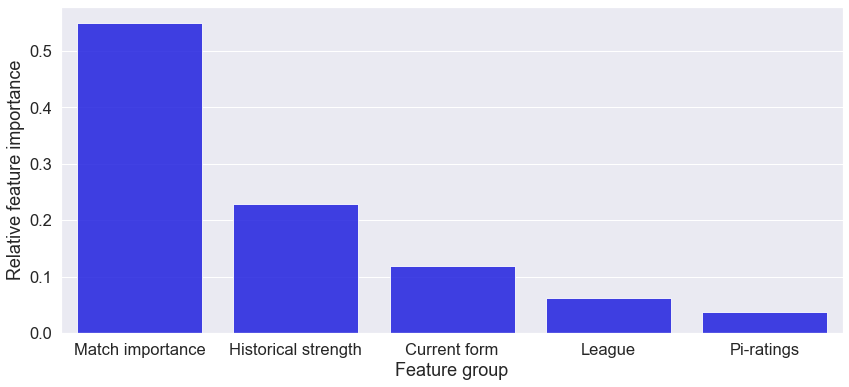

In [300]:
#keys = list(f_impor_perbucket.keys())
keys = ['Match importance', 'Historical strength', 'Current form', 'League', 'Pi-ratings']
vals = [float(f_impor_perbucket[k]) for k in keys]
sns.set_theme()
sns.set(font_scale=1.5)
plt.figure(figsize=(14,6))
ax = sns.barplot(x=keys, y=vals, alpha=.85, color='blue')
plt.xlabel("Feature group")
plt.ylabel("Relative feature importance")
plt.savefig("graphic_files/feature_importance.pdf", format='pdf', dpi=500, bbox_inches='tight')